Running v21 Sim (Annotated CUSUM): 500 Users, 60 Steps
Noisiest Malicious User: 5 (Peak ITS: 0.9315)


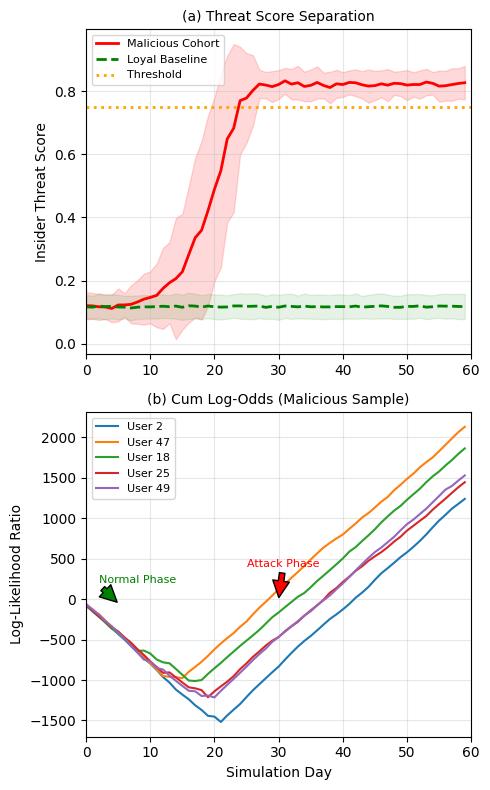

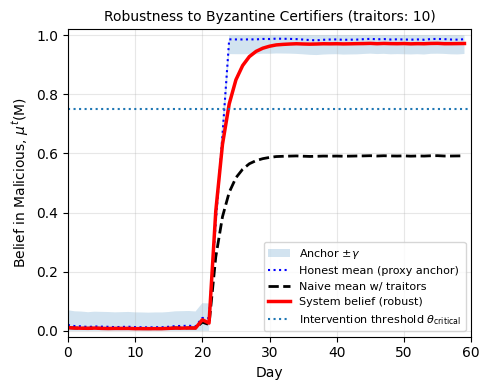

v21 Simulation Complete. Figures generated.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from dataclasses import dataclass
from enum import Enum
from scipy.stats import beta
import random
import os

# ============================================================================
# 1. CONFIGURATION
# ============================================================================

class UserType(Enum):
    LOYAL = 0
    DISGRUNTLED = 1 
    MALICIOUS = 2
    NEGLIGENT = 3 

@dataclass
class ChannelMetadata:
    index: int
    name: str
    category: str
    severity: float

# Experiment Config
NUM_USERS = 500
PCT_MAL = 0.1    # 20% Malicious (10 users)
HORIZON = 60
THRESHOLD = 0.75 
N_MEMBERS = 25    
F_TRAITORS = 10  
SACC_GAMMA = 0.05 # Clipping radius

# ============================================================================
# 2. CAUSAL DBN ENGINE
# ============================================================================

class CausalDependencyDBN:
    def __init__(self, channels):
        self.channels = channels
        # Likelihood params (Alpha, Beta)
        self.params = {
            UserType.LOYAL:      {'a': 2, 'b': 15}, 
            UserType.NEGLIGENT:  {'a': 3, 'b': 10}, 
            UserType.DISGRUNTLED:{'a': 5, 'b': 8},  
            UserType.MALICIOUS:  {'a': 12, 'b': 3}, 
        }

    def compute_log_likelihood(self, signals, user_type):
        log_prob = 0.0
        p = self.params.get(user_type, self.params[UserType.LOYAL])
        for idx, val in enumerate(signals):
            val = np.clip(val, 0.01, 0.99)
            log_prob += np.log(beta.pdf(val, p['a'], p['b']) + 1e-9)
        return log_prob

    def compute_threat_score(self, signals):
        score, weights = 0.0, 0.0
        for name, meta in self.channels.items():
            val = signals[meta.index]
            w = meta.severity
            if val > 0.6: w *= 1.5 
            if val > 0.8: w *= 2.0
            score += val * w
            weights += w
        return score / weights if weights > 0 else 0

# ============================================================================
# 3. GAME-THEORETIC AGENT
# ============================================================================

class UserAgent:
    def __init__(self, uid, is_malicious_scenario):
        self.uid = uid
        self.is_target = is_malicious_scenario
        self.type = UserType.LOYAL
        self.time = 0
        
        # === STOCHASTIC START TIMES ===
        self.start_day = np.random.randint(5, 15) if is_malicious_scenario else 999
        self.peak_day = self.start_day + np.random.randint(8, 15) 
        
        # Behavioral State (Continuous)
        self.stress = 0.0
        self.ref_point = 0.0  
        self.beta = 0.95      
        
        self.theta = {
            'trust_utility': 2.0,
            'attack_utility': 25.0, 
            'detection_cost': 8.0
        }
        self.current_action = 'NORMAL'
        self.cumulative_llr = 0.0 

    def update_state(self, t):
        self.time = t
        if not self.is_target: return

        if t < self.start_day:
            self.type = UserType.LOYAL
        elif self.start_day <= t < self.peak_day:
            self.type = UserType.DISGRUNTLED
            progress = (t - self.start_day) / (self.peak_day - self.start_day)
            self.stress = progress
            self.ref_point = 3.0 * progress       
            self.beta = 0.95 - (0.4 * progress)   
        else:
            self.type = UserType.MALICIOUS
            self.stress = 1.0
            self.ref_point = 5.0
            self.beta = 0.5

    def choose_action(self, current_belief):
        if self.type == UserType.LOYAL: 
            self.current_action = 'NORMAL'
            return 'NORMAL'
            
        if self.type == UserType.DISGRUNTLED:
            prob_recon = 0.1 + (0.5 * self.stress) 
            self.current_action = 'RECON' if np.random.random() < prob_recon else 'NORMAL'
            return self.current_action
        
        p_mal = current_belief
        risk_tolerance = 0.2 + (0.1 * self.ref_point) 
        
        risk_term = self.theta['detection_cost'] * p_mal * (1.0 / risk_tolerance)
        u_attack = self.theta['attack_utility'] - risk_term
        u_normal = self.theta['trust_utility']
        
        vals = np.array([u_normal, u_attack])
        inv_temp = 1.0 / self.beta 
        probs = np.exp(vals * inv_temp) / np.sum(np.exp(vals * inv_temp))
            
        if np.random.random() < probs[1]:
            self.current_action = 'EXFIL'
        else:
            self.current_action = 'RECON' 
            
        return self.current_action

    def generate_signals(self, action):
        num_channels = 4
        if action == 'NORMAL':
            return np.random.beta(2, 15, size=num_channels)
        elif action == 'RECON':
            return np.random.beta(5, 8, size=num_channels) 
        elif action == 'EXFIL':
            return np.random.beta(12, 3, size=num_channels) 
        return np.random.beta(2, 15, size=num_channels)

# ============================================================================
# 4. BYZANTINE COMMITTEE
# ============================================================================

class ByzantineCommittee:
    def __init__(self, channels):
        self.dbn = CausalDependencyDBN(channels)
        self.user_beliefs = {} 
        self.belief_history = {} 
        self.naive_beliefs = {} 

    def initialize_user(self, uid):
        self.user_beliefs[uid] = 0.01 
        self.naive_beliefs[uid] = 0.01
        self.belief_history[uid] = {'anchor': [], 'sacc': [], 'naive_smooth': [], 'traitor_vote': [], 'honest_votes': []}

    def certify(self, uid, signals):
        if uid not in self.user_beliefs: self.initialize_user(uid)
        
        prior = self.user_beliefs[uid]
        naive_prior = self.naive_beliefs[uid]
        
        # 1. Anchor Update
        likelihood_ratio = np.exp(self.dbn.compute_log_likelihood(signals, UserType.MALICIOUS) - 
                                  self.dbn.compute_log_likelihood(signals, UserType.LOYAL))
        anchor_post = (prior * likelihood_ratio) / ((prior * likelihood_ratio) + (1 - prior))
        
        # 2. Committee Voting
        reports = []
        honest_reports = []
        for _ in range(N_MEMBERS - F_TRAITORS):
            vote = np.clip(anchor_post + np.random.normal(0, 0.02), 0.01, 0.99)
            reports.append(vote)
            honest_reports.append(vote)
        
        # Traitor
        #traitor_vote = max(0.01, anchor_post * 0.4) 
        #traitor_vote = np.clip(traitor_vote, 0.01, 0.99)
        # Traitors: worst-case under-reporting given clipping.
        # They always try to vote 0; SACC will then clamp them to (anchor_post - SACC_GAMMA)
        # whenever anchor_post > SACC_GAMMA.
        traitor_vote = 0.0
        for _ in range(F_TRAITORS):
            reports.append(traitor_vote)
            
        # 3. Aggregation
        raw_naive_mean = np.mean(reports)
        
        # SACC
        clipped_reports = []
        for r in reports:
            if abs(r - anchor_post) > SACC_GAMMA:
                if r < anchor_post:
                    clipped_reports.append(anchor_post - SACC_GAMMA)
                else:
                    clipped_reports.append(anchor_post + SACC_GAMMA)
            else:
                clipped_reports.append(r)
        
        sacc_mean_val = np.mean(clipped_reports)
        
        # 4. Inertia
        alpha = 0.4 
        system_belief = (1 - alpha) * prior + alpha * sacc_mean_val
        naive_belief_smooth = (1 - alpha) * naive_prior + alpha * raw_naive_mean
        
        self.user_beliefs[uid] = system_belief
        self.naive_beliefs[uid] = naive_belief_smooth
        
        # Log
        self.belief_history[uid]['anchor'].append(anchor_post)
        self.belief_history[uid]['sacc'].append(system_belief)
        self.belief_history[uid]['naive_smooth'].append(naive_belief_smooth)
        self.belief_history[uid]['traitor_vote'].append(traitor_vote)
        self.belief_history[uid]['honest_votes'].append(honest_reports) # Log list of honest votes
        
        return system_belief

# ============================================================================
# 5. SIMULATION LOOP
# ============================================================================

def run_simulation():
    channels = {
        's_logon': ChannelMetadata(0, 's_logon', 'Access', 0.6),
        's_file': ChannelMetadata(1, 's_file', 'Recon', 0.7),
        's_role': ChannelMetadata(2, 's_role', 'Priv', 0.9),
        's_exfil': ChannelMetadata(3, 's_exfil', 'Exfil', 0.9)
    }
    
    committee = ByzantineCommittee(channels)
    logs = []
    n_mal = int(NUM_USERS * PCT_MAL)
    
    agents = [UserAgent(i, is_malicious_scenario=(i < n_mal)) for i in range(NUM_USERS)]

    print(f"Running v21 Sim (Annotated CUSUM): {NUM_USERS} Users, {HORIZON} Steps")

    for t in range(HORIZON):
        for uid in range(NUM_USERS):
            agent = agents[uid]
            agent.update_state(t)
            
            # Action & Signals
            current_belief = committee.user_beliefs.get(uid, 0.01)
            action = agent.choose_action(current_belief)
            signals = agent.generate_signals(action)
            
            # CUSUM Logic
            ll_mal = committee.dbn.compute_log_likelihood(signals, UserType.MALICIOUS)
            ll_loy = committee.dbn.compute_log_likelihood(signals, UserType.LOYAL)
            llr = ll_mal - ll_loy
            agent.cumulative_llr += llr 
            
            p_mal = committee.certify(uid, signals)
            its = committee.dbn.compute_threat_score(signals)
            hist = committee.belief_history[uid]

            # Helper to get mean of honest votes for logging/viz if needed
            honest_mean = np.mean(hist['honest_votes'][-1]) if hist['honest_votes'] else 0.0
            
            logs.append({
                'Day': t,
                'AgentID': uid,
                'Type': agent.type.name,
                'Action': action,
                'ITS': its,
                'RefPoint': agent.ref_point,
                'Beta': agent.beta,
                'P_Detect': p_mal,
                'Naive_Smooth': hist['naive_smooth'][-1],
                'IsTarget': agent.is_target,
                'Signals_Mean': np.mean(signals),
                'Traitor_Vote': hist['traitor_vote'][-1],
                'CUSUM': agent.cumulative_llr,
                'Honest_Mean': honest_mean
            })
            
    return pd.DataFrame(logs)

# ============================================================================
# 6. VISUALIZATION SUITE
# ============================================================================

class VisualizationSuite:
    @staticmethod
    def generate_all(df):
        VisualizationSuite.plot_fig1_separation(df)
        VisualizationSuite.plot_fig2_byz_robustness(df)
        #VisualizationSuite.plot_fig2_sacc_efficacy(df)
        #VisualizationSuite.plot_fig3_actions(df)
        #VisualizationSuite.plot_fig4_drift(df)

    @staticmethod
    def plot_fig1_separation(df):
        fig, axes = plt.subplots(2, 1, figsize=(5, 8))
        
        # Panel (a): Threat Score Separation
        ax = axes[0]
        targets = df[df['IsTarget']==True]
        baseline = df[df['IsTarget']==False]
        
        t_mean = targets.groupby('Day')['ITS'].mean()
        t_std = targets.groupby('Day')['ITS'].std()
        b_mean = baseline.groupby('Day')['ITS'].mean()
        b_std = baseline.groupby('Day')['ITS'].std()
        
        ax.plot(t_mean, 'r-', linewidth=2, label='Malicious Cohort')
        ax.fill_between(t_mean.index, t_mean - t_std, t_mean + t_std, color='r', alpha=0.15)
        ax.plot(b_mean, 'g--', linewidth=2, label='Loyal Baseline')
        ax.fill_between(b_mean.index, b_mean - b_std, b_mean + b_std, color='g', alpha=0.1)
        
        ax.axhline(THRESHOLD, color='orange', linestyle=':', linewidth=2, label='Threshold')
        ax.set_title("(a) Threat Score Separation", fontsize=10)
        ax.set_ylabel("Insider Threat Score")
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, HORIZON)
        
        # Panel (b): CUSUM (Malicious Only) - RANDOM SAMPLE
        ax = axes[1]
        all_mal_ids = targets['AgentID'].unique()
        n_sample = min(5, len(all_mal_ids))
        targets_to_plot = np.random.choice(all_mal_ids, n_sample, replace=False)
        
        for uid in targets_to_plot:
            d = targets[targets['AgentID']==uid]
            ax.plot(d['Day'], d['CUSUM'], linewidth=1.5, label=f'User {uid}')
        
        # === ANNOTATIONS ===
        # Assuming attack generally starts around day 10-15
        # Mark Normal Phase (Negative drift)
        ax.annotate("Normal Phase", xy=(5, -50), xytext=(2, 200),
                    arrowprops=dict(facecolor='green', shrink=0.05), fontsize=8, color='green')
        
        # Mark Attack Phase (Positive drift)
        ax.annotate("Attack Phase", xy=(30, 0), xytext=(25, 400),
                    arrowprops=dict(facecolor='red', shrink=0.05), fontsize=8, color='red')
            
        ax.set_title("(b) Cum Log-Odds (Malicious Sample)", fontsize=10)
        ax.set_xlabel("Simulation Day")
        ax.set_ylabel("Log-Likelihood Ratio")
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, HORIZON)
        
        plt.tight_layout()
        plt.savefig("fig1-dynamics.png")

    @staticmethod
    def plot_fig2_byz_robustness(df):
        """
        Figure 2: Robustness to Byzantine certifiers for a representative
        malicious user. Shows how the system belief tracks the honest
        consensus while the naive belief is suppressed by traitors.
        """
        fig, ax = plt.subplots(figsize=(5, 4))

        # Focus on malicious targets only
        targets = df[df['IsTarget'] == True]

        # Reuse your helper: highest peak ITS = "noisiest" malicious user
        uid = VisualizationSuite.get_noisiest_malicious_user(targets)
        if uid is None:
            print("No malicious user found for robustness plot.")
            return

        d = df[df['AgentID'] == uid].copy()

        # Smooth honest mean slightly for readability (proxy anchor)
        honest_smooth = d['Honest_Mean'].rolling(3, min_periods=1).mean()

        # --- NEW: shaded band for anchor ± gamma -------------------------
        # If your gamma is called something else (e.g. CLIP_GAMMA), swap it in.
        band_lower = np.clip(honest_smooth - SACC_GAMMA, 0.0, 1.0)
        band_upper = np.clip(honest_smooth + SACC_GAMMA, 0.0, 1.0)

        ax.fill_between(
            d['Day'],
            band_lower,
            band_upper,
            alpha=0.2,
            label=r"Anchor $\pm \gamma$"
        )
        # -----------------------------------------------------------------

        # Core curves: honest (proxy anchor), naive with traitors, system belief
        ax.plot(
            d['Day'],
            honest_smooth,
            'b:',
            linewidth=1.5,
            label='Honest mean (proxy anchor)'
        )
        ax.plot(
            d['Day'],
            d['Naive_Smooth'],
            'k--',
            linewidth=2,
            label='Naive mean w/ traitors'
        )
        ax.plot(
            d['Day'],
            d['P_Detect'],
            'r-',
            linewidth=2.5,
            label='System belief (robust)'
        )

        # Intervention threshold
        ax.axhline(
            THRESHOLD,
            linestyle=':',
            linewidth=1.5,
            label=r'Intervention threshold $\theta_{\mathrm{critical}}$'
        )

        ax.set_title(f"Robustness to Byzantine Certifiers (traitors: {F_TRAITORS})",
                    fontsize=10)
        ax.set_xlabel("Day")
        ax.set_ylabel(r"Belief in Malicious, $\mu^t(\mathrm{M})$")
        ax.set_xlim(0, HORIZON)
        ax.set_ylim(-0.02, 1.02)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', fontsize=8)

        plt.tight_layout()
        plt.savefig("fig2-byz-robustness.png")
        plt.show()
        plt.close()



    @staticmethod
    def get_noisiest_malicious_user(df):
        """
        Identifies the malicious user with the highest peak Insider Threat Score (ITS).
        """
        # Filter for Malicious users only
        malicious_df = df[df['Type'] == 'MALICIOUS']
        
        if malicious_df.empty:
            print("No malicious users found in the logs.")
            return None

        # Group by AgentID and find the max ITS for each agent
        max_scores = malicious_df.groupby('AgentID')['ITS'].max()
        
        # Find the AgentID with the highest maximum score
        noisiest_uid = max_scores.idxmax()
        peak_score = max_scores.max()
        
        print(f"Noisiest Malicious User: {noisiest_uid} (Peak ITS: {peak_score:.4f})")
        return noisiest_uid

# Example Usage:
# df = flatten_simulation_results(results)
# target_uid = get_noisiest_malicious_user(df)
    @staticmethod
    def plot_fig2_sacc_efficacy(df):
        fig, ax = plt.subplots(figsize=(5, 4))
        
        # Panel (a): SACC vs Naive - Single Representative (Randomly chosen)
        targets = df[df['IsTarget']==True]
        #all_mal_ids = targets['AgentID'].unique()
        uid = VisualizationSuite.get_noisiest_malicious_user(targets)
        d = df[df['AgentID']==uid]
        
        # Plot Honest Mean (Baseline Truth - Smoothed slightly for viz if noisy)
        honest_smooth = d['Honest_Mean'].rolling(3, min_periods=1).mean()
        ax.plot(d['Day'], honest_smooth, 'b:', linewidth=1.5, label='Honest Votes (Truth)')

        ax.plot(d['Day'], d['Naive_Smooth'], 'k--', linewidth=2, label='Naive (Suppressed)')
        ax.plot(d['Day'], d['P_Detect'], 'r-', linewidth=2.5, label='SACC (Robust)')
        
        ax.fill_between(d['Day'], d['Naive_Smooth'], d['P_Detect'],
                        color='green', alpha=0.2, label='SACC Protection')
        
        ax.axhline(THRESHOLD, color='orange', linestyle=':', label='Thresh')
        ax.set_title(f"(b) SACC Efficacy (User {uid})", fontsize=10)
        ax.set_xlabel("Day")
        ax.set_ylabel("System Belief")
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, HORIZON)
        
        plt.tight_layout()
        plt.savefig("fig2-resilience.png")

    @staticmethod
    def plot_fig3_actions(df):
        fig, ax = plt.subplots(figsize=(5, 4))
        act = df[df['IsTarget']==True].groupby(['Day','Action']).size().unstack(fill_value=0)
        cols = ['NORMAL', 'RECON', 'EXFIL']
        act = act[cols] if set(cols).issubset(act.columns) else act
        act.plot(kind='bar', stacked=True, ax=ax, width=1.0, color=['#3498db', '#e67e22', '#e74c3c'])
        ax.set_xticks(np.arange(0, HORIZON, 10))
        ax.set_title("Malicious Cohort Actions")
        plt.tight_layout()
        plt.savefig("fig3-actions.png")

    @staticmethod
    def plot_fig4_drift(df):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))
        targets = df[df['IsTarget']==True]
        for uid in targets['AgentID'].unique()[:5]:
            d = targets[targets['AgentID']==uid]
            ax1.plot(d['Day'], d['RefPoint'])
            ax2.plot(d['Day'], d['Beta'])
        ax1.set_title("Reference Point Drift")
        ax2.set_title("Beta Decay")
        plt.tight_layout()
        plt.savefig("fig4-drift.png")

# ============================================================================
# 7. MAIN
# ============================================================================

if __name__ == "__main__":
    sim = run_simulation()
    VisualizationSuite.generate_all(sim)
    print("v21 Simulation Complete. Figures generated.")